In [1]:
import freud
import gsd
import gsd.pygsd
import gsd.hoomd
import signac
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cycler
from scipy.stats import linregress

In [36]:
def atom_type_pos(snap, atom_type):
    if not isinstance(atom_type, list):
        atom_type = [atom_type]
    positions = []
    for atom in atom_type:
        indices = np.where(snap.particles.typeid == snap.particles.types.index(atom))
        positions.append(snap.particles.position[indices])
    return np.concatenate(positions)

def msd_from_gsd(gsdfile, start=-30, stop=-1, atom_type='ss', msd_mode = "window"):
    f = gsd.pygsd.GSDFile(open(gsdfile, "rb"))
    trajectory = gsd.hoomd.HOOMDTrajectory(f)
    positions = []
    for frame in trajectory[start:stop]:
        if atom_type == 'all':
            atom_positions = frame.particles.position[:]
        else:
            atom_positions = atom_type_pos(frame, atom_type)
        positions.append(atom_positions)
    msd = freud.msd.MSD(box=trajectory[-1].configuration.box, mode=msd_mode)
    msd.compute(positions)
    f.close()
    return(msd.msd) # This is retruning an array of numbers (the y-axis on the msd plot)

In [62]:
project = signac.get_project("/home/erjank_project/itic-project")


state_dict = {"size": "small",
              "density": 0.9,
              'process': 'quench',
             "molecule": "ITIC",
             'kT_reduced': 0.9}

for job in project:
    print(job.sp)
    
    
#state_dict['density.$lt'] = 1.3

{'molecule': 'ITIC', 'n_compounds': 480, 'density': 1.0, 'e_factor': 0.5, 'kT_reduced': 2.0, 'tau': 1, 'n_steps': 30000000.0, 'dt': 0.001, 'remove_hydrogens': True, 'original_id': '30903e72c835f2513bfb53a76ca3ed64', 'size': 'small', 'process': 'quench'}
{'molecule': 'ITIC', 'n_compounds': 480, 'density': 0.8, 'e_factor': 0.5, 'kT_reduced': 1.9, 'tau': 1, 'n_steps': 30000000.0, 'dt': 0.001, 'remove_hydrogens': True, 'original_id': 'e6d783ee40e99e443d6c865177914c41', 'size': 'small', 'process': 'quench'}
{'molecule': 'ITIC', 'n_compounds': 480, 'density': 1.15, 'e_factor': 0.5, 'kT_reduced': 1.7, 'tau': 1, 'n_steps': 30000000.0, 'dt': 0.001, 'remove_hydrogens': True, 'original_id': '2b2fb1ce5fcd09bf2e4be08448ecd14d', 'size': 'small', 'process': 'quench'}
{'molecule': 'ITIC', 'n_compounds': 480, 'density': 0.95, 'e_factor': 0.5, 'kT_reduced': 1.8, 'tau': 1, 'n_steps': 30000000.0, 'dt': 0.001, 'remove_hydrogens': True, 'original_id': '85ed6c246c60be7f6eee0d2e4f63c44c', 'size': 'small', 'pr

{'molecule': 'ITIC', 'n_compounds': 960, 'density': 0.85, 'e_factor': 0.5, 'kT_reduced': 2.1, 'tau': 1, 'n_steps': 30000000.0, 'dt': 0.001, 'remove_hydrogens': True, 'original_id': '3a34fb0f58214d6eba35141139dac8be', 'size': 'medium', 'process': 'quench'}
{'molecule': 'ITIC', 'n_compounds': 960, 'density': 1.15, 'e_factor': 0.5, 'kT_reduced': 1.8, 'tau': 1, 'n_steps': 30000000.0, 'dt': 0.001, 'remove_hydrogens': True, 'original_id': 'bc8d7d0724752b404b26369fd4047ab1', 'size': 'medium', 'process': 'quench'}
{'molecule': 'ITIC', 'n_compounds': 960, 'density': 1.0, 'e_factor': 0.5, 'kT_reduced': 2.3, 'tau': 1, 'n_steps': 30000000.0, 'dt': 0.001, 'remove_hydrogens': True, 'original_id': 'f93d717be1ab32b0a3a706cae2d69bc3', 'size': 'medium', 'process': 'quench'}
{'molecule': 'ITIC', 'n_compounds': 960, 'density': 1.15, 'e_factor': 0.5, 'kT_reduced': 2.4, 'tau': 1, 'n_steps': 30000000.0, 'dt': 0.001, 'remove_hydrogens': True, 'original_id': '7a58918e36c036b8f67398271bd0a9d1', 'size': 'medium'

slope is:
1.01730e-07


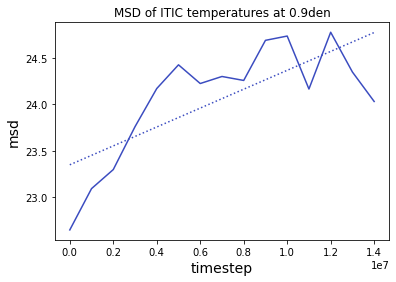

In [63]:
job_list = project.find_jobs(state_dict)
fig = plt.figure()
ax = plt.subplot(111)
color = plt.cm.coolwarm(np.linspace(0, 1, len(job_list)))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
for kT,job in job_list.groupby('kT_reduced'):
    job = list(job)[0]
    tspf = job.sp['n_steps'] / 100
    msd = msd_from_gsd(job.fn('trajectory.gsd'), atom_type='all')
    y = msd[-15:]
    x = np.arange(0, len(y), 1) * tspf
    #plt.xlim(0, 6000)
    plt.plot(x, y, label=job.sp['kT_reduced'])
plt.title("MSD of ITIC temperatures at %sden" % (job.sp['density']))
plt.xlabel("timestep", fontsize=14)
plt.ylabel("msd", fontsize=14)
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)



slope, intercept, r_value, p_value, std_err = linregress(x, y)
plt.plot(x, x*slope + intercept, linestyle = 'dotted')
print("slope is:")
print("%10.5e"% slope)

#job.doc.msd_slope = slope

plt.show()

In [ ]:
#30,000,000 timesteps maybe